# **Clustering Part 2**

Investigating DBSCAN and HAC on NFL Datasets

#### **Imports**

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


# K means stuff
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
BDB_All_Plays_Model_Ready = pd.read_csv("../../Feature_Subsets/BDB_All_Plays_Model_Ready.csv")
PDA_Model_Ready = pd.read_csv("../../AFL_Final_Project/PDA_Model_Ready.csv") # Punt Data Analytics
FNF_Model_Ready = pd.read_csv("../../AFL_Final_Project/FNF_Model_Ready.csv") # First and Future

### **Big Data Bowl - DBSCAN Clustering**

Pre-Processing: PCA for BDB

In [6]:
Xbdb = BDB_All_Plays_Model_Ready.drop(columns=['Inj_Occured'])
ybdb = BDB_All_Plays_Model_Ready['Inj_Occured']

In [9]:
nuniques = Xbdb.nunique(dropna=True)     # change this here
numeric_cols = nuniques.index[nuniques > 2].tolist()
onehot_cols  = nuniques.index[nuniques == 2].tolist()

num_branch = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pre = ColumnTransformer([
    ('num_pca', num_branch, numeric_cols),
    ('cat', 'passthrough', onehot_cols)
], remainder='drop')

In [11]:
pre.fit(Xbdb,ybdb)

bdbpca = pre.named_transformers_['num_pca'].named_steps['pca']

print("Number of PCA components:", bdbpca.n_components_)
print("Explained variance ratio:", bdbpca.explained_variance_ratio_)
print("Cumulative variance:", bdbpca.explained_variance_ratio_.cumsum())

Number of PCA components: 9
Explained variance ratio: [0.1717829  0.15000998 0.14061044 0.11333325 0.10831448 0.09639283
 0.07967639 0.07483798 0.06504175]
Cumulative variance: [0.1717829  0.32179288 0.46240332 0.57573657 0.68405105 0.78044388
 0.86012027 0.93495825 1.        ]


In [12]:
Xbdb_trans = pre.transform(Xbdb)

# Optional: build a nice DF
pca_cols = [f"PC{i+1}" for i in range(bdbpca.n_components_)]
final_cols = pca_cols + onehot_cols
Xbdb_trans_df = pd.DataFrame(Xbdb_trans, columns=final_cols, index=Xbdb.index)

Re-sample to keep things managable in terms of compute and and set MinPTs to the number of PCs

In [16]:
X_bdb_small = resample(
    Xbdb_trans_df,
    n_samples=5000,
    random_state=42
)

MinPts = 9 # Setting this to the same size as the PCA Components  

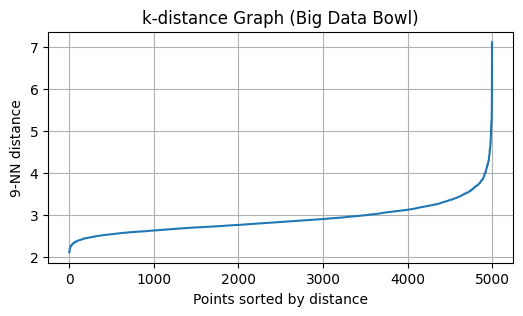

In [19]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(X_bdb_small)
distances, indices = neighbors_fit.kneighbors(X_bdb_small)

k_dist = np.sort(distances[:, MinPts-1])
plt.figure(figsize=(6,3))
plt.plot(k_dist)
plt.title("k-distance Graph (Big Data Bowl)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{MinPts}-NN distance")
plt.grid(True)
plt.show()

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_guess = 3.2  # ← adjust based on elbow

dbscan_bdb = DBSCAN(eps=eps_guess, min_samples=MinPts)
labels_bdb = dbscan_bdb.fit_predict(X_bdb_small)

unique, counts = np.unique(labels_bdb, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))

if len(set(labels_bdb)) > 1:
    core_mask = labels_bdb != -1
    sil = silhouette_score(X_bdb_small[core_mask], labels_bdb[core_mask])
    print("Silhouette score (no noise):", sil)

Cluster counts: {-1: 339, 0: 4629, 1: 15, 2: 9, 3: 8}
Silhouette score (no noise): 0.1265056351673687


Make blobs

Cluster counts: {-1: 433, 0: 4567}
Estimated number of clusters: 1


/var/folders/wg/hrk6rd4s2mv7ztvpxryxn48c0000gn/T/ipykernel_5867/2544775637.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


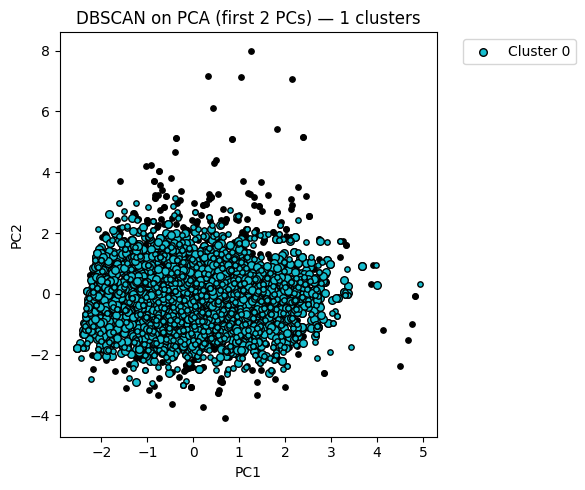

In [24]:
eps_guess = 3.2
MinPts    = 18

# Fit DBSCAN on PCA sample
dbscan_bdb = DBSCAN(eps=eps_guess, min_samples=MinPts)
labels_bdb = dbscan_bdb.fit_predict(X_bdb_small)

# Core samples mask (use labels_bdb and dbscan_bdb)
core_samples_mask = np.zeros_like(labels_bdb, dtype=bool)
core_samples_mask[dbscan_bdb.core_sample_indices_] = True

# Number of clusters (ignore noise = -1)
unique_labels = sorted(set(labels_bdb))
n_clusters_ = len([k for k in unique_labels if k != -1])

unique, counts = np.unique(labels_bdb, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))
print("Estimated number of clusters:", n_clusters_)

# First two PCs for plotting
X_plot = X_bdb_small.iloc[:, :2].to_numpy()

# Color map that can handle many clusters
colors = plt.cm.get_cmap("tab10", len(unique_labels))

plt.figure(figsize=(6, 5))

for idx, k in enumerate(unique_labels):
    class_member_mask = (labels_bdb == k)

    if k == -1:
        col = "k"
        label = "Noise"
    else:
        col = colors(idx)
        label = f"Cluster {k}"

    # Core points
    xy = X_plot[class_member_mask & core_samples_mask]
    plt.scatter(
        xy[:, 0], xy[:, 1],
        s=30,
        c=[col],
        edgecolors="k",
        label=label if xy.shape[0] > 0 else None
    )

    # Border points
    xy = X_plot[class_member_mask & ~core_samples_mask]
    plt.scatter(
        xy[:, 0], xy[:, 1],
        s=15,
        c=[col],
        edgecolors="k"
    )

plt.title(f"DBSCAN on PCA (first 2 PCs) — {n_clusters_} clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### **First and Future**

PCA 